In [1]:
import sys
assert sys.version_info >= (3, 7)

Note that you need python 3.7 to have use datetime.datetime.fromisoformat()

In [31]:
import csv 
import numpy as np
from functions import split
from functions import pipeline
from functions import load_data
from functions import compute_f1
from functions import corr_matrix
from functions import plot_feature
from functions import print_sample
from functions import convert_date
from functions import convert_type
from functions import print_feature
from functions import remove_missing
from functions import delete_feature
from functions import sort_by_station
from functions import convert_one_hot
from functions import convert_weather
from functions import sort_by_duration
from functions import feature_output_corr
from functions import normalization_feature
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score

# Loading and Preprocessing :

* path : (STRING) path of the file to load.
* limit : (INT) limit the number of example to load.
* delete_features : (LIST) feature names to remove.
* cvrt_date : (BOOLEAN) convert the data
* weather : (LIST) weather to consider. All other will be dropped.
* one_hot_features : (LIST) feature names to convert in one-hot vector.
* norm_features : (LIST) feature names to normalize in one-hot vector
* missing_features (LIST) feature which missing values are to replace 
* missing_values   (LIST) value with which to replace the missing values

### Training file:

In [5]:
header, x, y, label = pipeline(path="data/training.csv")

Data loaded (4.9s)
Visility indicator deleted (5.7s)
hmdx deleted (5.0s)
Wind Chill deleted (6.4s)
Date splited in Year/Month/Day/Hour/Weekday (7.5s)
Weekday converted in one-hot vector (14.5s)
Weather converted (21.6s)
Replace missing values (0.2s)
Remove samples with missing values (0.7s)
Data converted to float (11.4s)
Temperature (°C) normalized (14.2s)
Drew point (°C) normalized (14.8s)
Relativite humidity (%) normalized (14.3s)
wind direction (10s deg) normalized (14.1s)
Wind speed (km/h) normalized (13.4s)
Pressure at the station (kPa) normalized (16.3s)
Visibility (km) normalized (15.4s)
Sort data according to station code (0.7s)
split data into x, y, and label (52.3s)


In [6]:
header, stations, x_stations, y_stations, label_stations = sort_by_station(header, x, y, label)

### Test file:

In [7]:
header_test, x_test = pipeline(path="data/test.csv", test=True)

Data loaded (0.9s)
Visility indicator deleted (1.8s)
hmdx deleted (1.7s)
Wind Chill deleted (2.9s)
Date splited in Year/Month/Day/Hour/Weekday (2.0s)
Weekday converted in one-hot vector (3.9s)
Weather converted (4.0s)
Replace missing values (0.0s)
Remove samples with missing values (0.1s)
Data converted to float (2.1s)
Temperature (°C) normalized (5.1s)
Drew point (°C) normalized (3.9s)
Relativite humidity (%) normalized (3.8s)
wind direction (10s deg) normalized (3.9s)
Wind speed (km/h) normalized (3.7s)
Pressure at the station (kPa) normalized (4.1s)
Visibility (km) normalized (5.4s)
Sort data according to station code (0.2s)


In [8]:
header, stations_test, x_test_stations  = sort_by_station(header_test, x_test)

In [9]:
assert(stations == stations_test)

# Model logistic par station

In [42]:
yi = header_test.index("Year")
mi = header_test.index("Month")
di = header_test.index("Day")
hi = header_test.index("Hour")
si = header_test.index("Station Code")

f1mean = []

with open("data/results.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(["id","volume"])
    
    for i, s in enumerate(stations):
        
        # if empty (no recording for that station in test set)
        if not x_test_stations[i]:
            continue
        
        # sort by time
        _x, _y, _label = sort_by_duration(header, x_stations[i], y_stations[i], label_stations[i])

        #deleting outliers + Dealing with sqrt(y) instead of y
#         non_out_ind = np.where(np.asarray(_y) < 50)
#         _x = np.asarray(_x)[non_out_ind].tolist()
#         _y = np.asarray(_y)[non_out_ind].tolist() 
#         _label = np.asarray(_label)[non_out_ind].tolist()
        
        # create validation set
        split = int(0.8*len(_x))
        x_train, x_valid = _x[:split],  _x[split:]
        y_train, y_valid = _y[:split],  _y[split:]
        label_train, label_valid = _label[:split],  _label[split:]
        
#         # Linear model
#         model_linear = LinearRegression()
#         model_linear = model_linear.fit(x_train, y_train)

#         # evaluate model
#         y_pred = model_linear.predict(x_valid)
#         label_pred = [int(y > np.sqrt(8)) for y in y_pred]
#         f1_score, threshold = compute_f1(label_pred, label_valid)
#         f1mean.append(f1_score)
        
#         # prediction
#         y_test = model_linear.predict(x_test_stations[i])
        
#         label_test = [int(y > np.sqrt(8)) for y in y_test]
        
        # regression logistic
        weights = 1
        best_f1_score, best_class_weight, best_threshold = 0, 0, 0
        
        for wi in range(10):
            model = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: wi}, solver="lbfgs")
            model.fit(x_train, label_train)

            # evaluate model
            proba_valid = list(zip(*model.predict_proba(x_valid)))[1]
            f1_score, threshold = compute_f1(proba_valid, label_valid)
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_class_weight = wi
                best_threshold = threshold

        f1mean.append(best_f1_score)

        model = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: best_class_weight}, solver="lbfgs")
        model.fit(_x, _label)
        
        # prediction
        proba_test = list(zip(*model.predict_proba(x_test_stations[i])))[1]
        
        label_test = [int(p > best_threshold) for p in proba_test]
        
        print ("{}/{} Stations done".format(i+1, len(stations)) , end="\r")
        
        # write prediction in file
        for i, (e, p) in enumerate(zip(x_test_stations[i], label_test)):
            d = "2016-{:02d}-{:02d}_{:02d}:00_{:4d}".format(int(e[mi]),int(e[di]),int(e[hi]),int(e[si]))
            writer.writerow([d, str(bool(p))])
print("")
print("Done!")
print("f1-score mean : {:4f}".format(np.mean(f1mean)))

182/182 Stations done
Done!
f1-score mean : 0.471134


# To continue

### Deleting Outliers

In [9]:
header=np.asarray(header)
x=np.asarray(x)
y=np.asarray(y)
label=np.asarray(label)

In [10]:
print("Quantile at 0.99:", np.quantile(y, 0.99))
print("10 Highest values:", sorted(y, reverse = True)[0:10])

Quantile at 0.99: 17.0
10 Highest values: [179.0, 169.0, 169.0, 156.0, 156.0, 125.0, 123.0, 115.0, 109.0, 109.0]


In [11]:
non_out_ind = np.where(y < 50)
x, y, label = x[non_out_ind], y[non_out_ind], label[non_out_ind]

#### Distribution of the withdrawals:

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


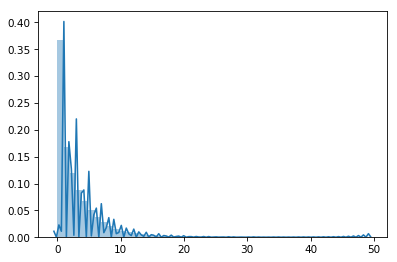

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4), dpi=75)
sns.distplot(y)
plt.show()

To reduce the tail of the distribution, we apply the square root function to to $y$ :

In [13]:
y = np.sqrt(y)

split = int(x.shape[0] * 0.8)
x_train, x_valid = x[:split], x[split:]
y_train, y_valid = y[:split], y[split:]
label_train, label_valid = label[:split], label[split:]

### Forward Feature Selection 

In [14]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared


#Initialization variables
Y = y_train
X = x_train
k = 25
# k = len(header)

remaining_features = [i for i in range(len(header))]
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[:,list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [15]:
for i in range(1,len(features_list)):
    features_list[i] = [f for f in features_list[i] if header[f] in header_test]

print('Forward stepwise subset selection')
for i in range(1,20):
    print('Number of features :', len(features_list[i]))
    print('Features :', features_list[i])
    print('RSS :', round(RSS_list[i]))
    print('R Squared :', R_squared_list[i])
    print("")

Forward stepwise subset selection
Number of features : 1
Features : [0]
RSS : 1337225.0
R Squared : 0.1478101732415248

Number of features : 2
Features : [0, 2]
RSS : 1197326.0
R Squared : 0.2369656185666592

Number of features : 3
Features : [0, 2, 12]
RSS : 1123123.0
R Squared : 0.2842536583364178

Number of features : 4
Features : [0, 2, 12, 5]
RSS : 1108891.0
R Squared : 0.29332342711774484

Number of features : 5
Features : [0, 2, 12, 5, 8]
RSS : 1102947.0
R Squared : 0.29711162107018985

Number of features : 6
Features : [0, 2, 12, 5, 8, 19]
RSS : 1098416.0
R Squared : 0.29999913997376215

Number of features : 7
Features : [0, 2, 12, 5, 8, 19, 10]
RSS : 1096273.0
R Squared : 0.30136449094495454

Number of features : 8
Features : [0, 2, 12, 5, 8, 19, 10, 18]
RSS : 1094619.0
R Squared : 0.30241877443183995

Number of features : 9
Features : [0, 2, 12, 5, 8, 19, 10, 18, 7]
RSS : 1093336.0
R Squared : 0.30323658911782225

Number of features : 10
Features : [0, 2, 12, 5, 8, 19, 10, 18

Features that we choose to keep :

In [16]:
features_keep = features_list[10]

x_train = x_train[:, features_keep]
x_valid = x_valid[:, features_keep]

### Linear regression on Withdrawals:

In [17]:
model_linear = LinearRegression()
model_linear = model_linear.fit(x_train, y_train)

y_pred = model_linear.predict(x_valid)

# The coefficients
print('Score: ', model_linear.score(x_valid, y_valid))
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_valid, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_valid, y_pred))

Score:  -0.4797704769167009
Mean squared error: 1.58
Variance score: -0.48


### Logistic regression between Withdrawals and Volume:

In [18]:
from sklearn.linear_model import LogisticRegression

model_logit = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: 6})
model_logit = model_logit.fit(y_train.reshape(-1,1), label_train)

print(model_logit.score(y_valid.reshape(-1,1), label_valid))
print(model_logit.score(model_linear.predict(x_valid).reshape(-1,1), label_valid))

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0
0.9177681925699179


## Creation of the result file:

In [19]:
features_keep_test = [np.where(i == header_test)[0][0] 
                      for i in header[features_keep]]
x_test_f = x_test[:,features_keep_test]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
label_pred = model_logit.predict(model_linear.predict(x_test_f).reshape(-1,1))

In [ ]:
yi = np.where(header_test == "Year")
mi = np.where(header_test == "Month")
di = np.where(header_test == "Day")
hi = np.where(header_test == "Hour")
si = np.where(header_test == "Station Code")

results = [["id","volume"]]

for index,element in enumerate(x_test):
    string_element = "2016-{:02d}-{:02d}_{:02d}:00_{:4d}".format(int(element[mi]),
                                                                 int(element[di]),
                                                                 int(element[hi]),
                                                                 int(element[si]))
    results.append([string_element, str(bool(label_pred[index]))])

In [ ]:
print(sum(model_logit.predict(model_linear.predict(x_valid).reshape(-1,1))))
print(sum(model_logit.predict(model_linear.predict(x_test_f).reshape(-1,1))))

In [ ]:
import csv 

with open("data/results.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(results)